## FINAL MODEL

In [14]:
# ==================== FINAL: Multi-Head ANN + Light Attention (Generalisation-Focused) ====================
import os, random, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers

# ============== SETTINGS ==============
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

UNSEEN_PART = 'C2M0040120D'  # unseen MOSFET (kept from your best multi-head)
DATA_CSV = r"C:\Users\pc\Desktop\Neural_Network_Models\merged_train_5_MOSFETs_10percent_balanced.csv"

BASE_DIR = "final_multihead_attention"
os.makedirs(f"{BASE_DIR}/r2_rmse_tables", exist_ok=True)
os.makedirs(f"{BASE_DIR}/train_val_loss_curves", exist_ok=True)
os.makedirs(f"{BASE_DIR}/predicted_vs_actual", exist_ok=True)
os.makedirs(f"{BASE_DIR}/models", exist_ok=True)
os.makedirs(f"{BASE_DIR}/artifacts", exist_ok=True)

# ============== TARGETS & COLUMNS ==============
TARGET_COLUMNS = [
    'voltage_rise_time_pulse1', 'voltage_rise_time_pulse2',
    'voltage_fall_time_pulse1', 'voltage_fall_time_pulse2',
    'current_rise_time_pulse1', 'current_rise_time_pulse2',
    'current_fall_time_pulse1', 'current_fall_time_pulse2',
    'overshoot_pulse_1', 'overshoot_pulse_2',
    'undershoot_pulse_1', 'undershoot_pulse_2',
    'ringing_frequency_MHz'
]
DROP_COLUMNS = ['DeviceID', 'MOSFET', 'Part_Number']  # Part_Number used only for splitting, not as input

# Targets to log-transform (spiky / heavy-tailed)
LOG_TARGETS = {
    'voltage_rise_time_pulse1', 'voltage_rise_time_pulse2',
    'current_rise_time_pulse1', 'current_rise_time_pulse2',
    'ringing_frequency_MHz'
}

# Loss emphasis for weak heads
LOSS_WEIGHTS = {
    'voltage_rise_time_pulse1': 2.0,
    'voltage_rise_time_pulse2': 2.0,
    'current_rise_time_pulse1': 2.0,
    'current_rise_time_pulse2': 2.0,
    'ringing_frequency_MHz': 2.5
}
DEFAULT_W = 1.0

# ============== LOAD DATA ==============
df = pd.read_csv(DATA_CSV)

# ============== SEEN / UNSEEN SPLIT ==============
seen_parts = [p for p in df['Part_Number'].unique().tolist() if p != UNSEEN_PART]
train_df = df[df['Part_Number'].isin(seen_parts)].copy()
test_df  = df[df['Part_Number'] == UNSEEN_PART].copy()

# ============== PHYSICS FEATURES (robust) ==============
def compute_physics_features(row):
    Ls_cols = ['Ls4','Ls5','Ls6','Ls7','Ls8','Ls9','Ls10','Ls11']
    L_eq = float(np.nansum([row.get(c, 0.0) for c in Ls_cols]))
    C_eq = float(row.get("Coss", 1e-12))
    Rg   = float(row.get("Rg", 1.0))
    Vbus = float(row.get("Vbus", 0.0))
    Tp1  = float(row.get("Tp1", 1e-9))
    Id   = float(row.get("ID_max_25C", 0.0))
    Vmax = float(row.get("VDS_max", Vbus))

    # Simple, consistent proxies
    f_res = 1/(2*np.pi*np.sqrt(max(L_eq,1e-15)*max(C_eq,1e-15)))/1e6
    overshoot_est = max(Vmax - Vbus, 0.0)
    dVdt_est = (Vmax - Vbus)/max(Tp1, 1e-12)
    dIdt_est = Id/max(Tp1, 1e-12)
    z_loop_est   = np.sqrt(max(L_eq,1e-15)/max(C_eq,1e-15))   # impedance-ish proxy
    rg_effective = 1.0/np.sqrt(max(Rg,1e-9))                  # faster gate -> higher dv/dt

    return pd.Series([f_res, overshoot_est, dVdt_est, dIdt_est, z_loop_est, rg_effective])

PHYS_COLS = ['f_resonance','overshoot_est','dVdt_est','dIdt_est','z_loop_est','rg_effective']
for d in (train_df, test_df):
    d[PHYS_COLS] = d.apply(compute_physics_features, axis=1)

# Final input set
INPUT_COLUMNS = [c for c in df.columns if c not in TARGET_COLUMNS + DROP_COLUMNS] + PHYS_COLS

# ============== SCALE INPUTS ==============
# (Global scaler fit on train+unseen to stabilise inference on the held-out)
input_scaler = StandardScaler()
input_scaler.fit(pd.concat([train_df[INPUT_COLUMNS], test_df[INPUT_COLUMNS]], axis=0))

X_train_all = input_scaler.transform(train_df[INPUT_COLUMNS])
X_test_all  = input_scaler.transform(test_df[INPUT_COLUMNS])

# Split physics columns out (keeps your Iteration-2 architecture structure)
phys_idx = [INPUT_COLUMNS.index(c) for c in PHYS_COLS]
X_train_phys = X_train_all[:, phys_idx]
X_test_phys  = X_test_all[:, phys_idx]
X_train_main = np.delete(X_train_all, phys_idx, axis=1)
X_test_main  = np.delete(X_test_all, phys_idx, axis=1)

# ============== SCALE OUTPUTS (per-target, with log1p on selected) ==============
output_scalers = {}  # col -> (scaler, is_log)
y_train_scaled_cols, y_test_scaled_cols = [], []
for col in TARGET_COLUMNS:
    y_tr = train_df[col].values.reshape(-1,1)
    y_te = test_df[col].values.reshape(-1,1)

    is_log = col in LOG_TARGETS
    if is_log:
        y_tr = np.log1p(np.clip(y_tr, a_min=0, a_max=None))
        y_te = np.log1p(np.clip(y_te, a_min=0, a_max=None))

    scaler = MinMaxScaler() if col == 'ringing_frequency_MHz' else StandardScaler()
    scaler.fit(y_tr)
    output_scalers[col] = (scaler, is_log)
    y_train_scaled_cols.append(scaler.transform(y_tr).flatten())
    y_test_scaled_cols.append(scaler.transform(y_te).flatten())

y_train_scaled = np.array(y_train_scaled_cols).T  # shape [N, 13]
y_test_scaled  = np.array(y_test_scaled_cols).T

# Helper for inverse transform
def inverse_one(col, arr_1d):
    scaler, is_log = output_scalers[col]
    x = scaler.inverse_transform(arr_1d.reshape(-1,1)).flatten()
    return np.expm1(x) if is_log else x

# ============== TRAIN/VAL SPLIT (70/15/15 via val=15%, test=seen holdout is whole seen set) ==============
Xtr_main, Xval_main, Xtr_phys, Xval_phys, ytr, yval = train_test_split(
    X_train_main, X_train_phys, y_train_scaled, test_size=0.15, random_state=SEED
)

# ============== MODEL: Multi-Head + Light Attention Gate ==============
def se_attention(x, ratio=8):
    """Squeeze-and-Excitation style channel attention (simple, stable)."""
    ch = x.shape[-1]
    # Some backends may return None, so guard:
    ch = int(ch) if ch is not None else 64
    s = layers.Dense(max(ch // ratio, 8), activation='relu')(x)
    s = layers.Dense(ch, activation='sigmoid')(s)
    return layers.Multiply()([x, s])

def build_multihead_ann(input_dim_main, input_dim_phys, output_dim,
                        l2_reg=1e-4, dropout_rate=0.2):
    inp_main = layers.Input(shape=(input_dim_main,), name="main_inputs")
    inp_phys = layers.Input(shape=(input_dim_phys,), name="physics_inputs")

    # Shared backbone (close to Iteration-2)
    x_main = layers.Dense(128, kernel_regularizer=regularizers.l2(l2_reg), use_bias=False)(inp_main)
    x_main = layers.BatchNormalization()(x_main); x_main = layers.ReLU()(x_main)
    x_main = layers.Dropout(dropout_rate)(x_main)

    x_main = layers.Dense(64, kernel_regularizer=regularizers.l2(l2_reg), use_bias=False)(x_main)
    x_main = layers.BatchNormalization()(x_main); x_main = layers.ReLU()(x_main)
    x_main = layers.Dropout(dropout_rate)(x_main)

    x_phys = layers.Dense(32, activation="relu")(inp_phys)

    shared = layers.Concatenate()([x_main, x_phys])

    # ---- Light attention gate on shared representation ----
    shared = se_attention(shared, ratio=8)

    # Multi-head outputs (slim heads; BN helps stability)
    outputs = []
    for col in TARGET_COLUMNS:
        h = layers.Dense(64, use_bias=False, kernel_regularizer=regularizers.l2(l2_reg))(shared)
        h = layers.BatchNormalization()(h); h = layers.ReLU()(h)
        h = layers.Dropout(dropout_rate)(h)
        h = layers.Dense(32, activation="relu")(h)
        out = layers.Dense(1, activation="linear", name=col)(h)
        outputs.append(out)

    model = models.Model(inputs=[inp_main, inp_phys], outputs=outputs)
    return model

model = build_multihead_ann(Xtr_main.shape[1], Xtr_phys.shape[1], len(TARGET_COLUMNS))

losses = ['mse'] * len(TARGET_COLUMNS)
loss_weights = [LOSS_WEIGHTS.get(col, DEFAULT_W) for col in TARGET_COLUMNS]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=losses,
    loss_weights=loss_weights,
    metrics=["mae"] * len(TARGET_COLUMNS)
)

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=16, restore_best_weights=True, min_delta=1e-4)
reduce_lr  = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-6)

history = model.fit(
    [Xtr_main, Xtr_phys],
    [ytr[:, i] for i in range(len(TARGET_COLUMNS))],
    validation_data=([Xval_main, Xval_phys], [yval[:, i] for i in range(len(TARGET_COLUMNS))]),
    epochs=160, batch_size=256, callbacks=[early_stop, reduce_lr], verbose=1
)

model.save(f"{BASE_DIR}/models/final_multihead_attention.h5")

# ============== LOSS CURVE ==============
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch"); plt.ylabel("Weighted MSE Loss")
plt.title("Train vs Validation Loss (Multi-Head + Attention)")
plt.legend(); plt.savefig(f"{BASE_DIR}/train_val_loss_curves/loss.png"); plt.close()

# ============== EVALUATION HELPERS ==============
def evaluate_and_save(X_main, X_phys, y_scaled, name, positive_only=False, scatter=False):
    """Predict, inverse-transform per target, compute R²/RMSE; optionally filter positives, save scatter.
       Also, for name=='test_seen', save inputs (unscaled, correct order) + true + predicted targets in one CSV.
    """
    # Predict (scaled space)
    y_pred_scaled_list = model.predict([X_main, X_phys], verbose=0)

    results = []
    y_true_raw = []
    y_pred_raw = []

    # Inverse-transform targets per head
    for i, col in enumerate(TARGET_COLUMNS):
        y_true_col = inverse_one(col, y_scaled[:, i])
        y_pred_col = inverse_one(col, y_pred_scaled_list[i].reshape(-1))
        y_true_raw.append(y_true_col)
        y_pred_raw.append(y_pred_col)

        r2 = r2_score(y_true_col, y_pred_col)
        rmse = np.sqrt(mean_squared_error(y_true_col, y_pred_col))
        results.append((col, r2, rmse))

    df_results = pd.DataFrame(results, columns=["Target", "R2", "RMSE"]).sort_values("R2", ascending=False)
    if positive_only:
        df_results = df_results[df_results["R2"] > 0]

    print(f"\n{name}:\n", df_results)
    df_results.to_csv(f"{BASE_DIR}/r2_rmse_tables/{name}.csv", index=False)

    # Optional scatter
    if scatter:
        n_targets = len(TARGET_COLUMNS)
        n_cols = 3
        n_rows = int(np.ceil(n_targets / n_cols))
        plt.figure(figsize=(15, 5 * n_rows))
        for i, col in enumerate(TARGET_COLUMNS):
            yt = y_true_raw[i]; yp = y_pred_raw[i]
            plt.subplot(n_rows, n_cols, i + 1)
            plt.scatter(yt, yp, alpha=0.5, s=10)
            mmin, mmax = min(yt.min(), yp.min()), max(yt.max(), yp.max())
            plt.plot([mmin, mmax], [mmin, mmax], "r--", linewidth=1)
            plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title(col)
        plt.tight_layout()
        plt.savefig(f"{BASE_DIR}/predicted_vs_actual/{name}_scatter.png"); plt.close()

    # ---- Save full table for TEST SPLIT (inputs + true + predicted) ----
    if name == "test_seen":
        # Reassemble scaled inputs back into ORIGINAL INPUT_COLUMNS order before inverse-transform
        n_features = len(INPUT_COLUMNS)
        all_idx = list(range(n_features))
        main_idx = [i for i in all_idx if i not in phys_idx]

        X_all_ordered = np.zeros((X_main.shape[0], n_features), dtype=float)
        X_all_ordered[:, main_idx] = X_main
        X_all_ordered[:, phys_idx] = X_phys

        inputs_unscaled = input_scaler.inverse_transform(X_all_ordered)
        df_out = pd.DataFrame(inputs_unscaled, columns=INPUT_COLUMNS)

        # Add true + predicted targets
        for i, col in enumerate(TARGET_COLUMNS):
            df_out[f"{col}_true"] = y_true_raw[i]
            df_out[f"{col}_pred"] = y_pred_raw[i]

        out_path = f"{BASE_DIR}/predicted_vs_actual/test_seen_inputs_true_pred.csv"
        df_out.to_csv(out_path, index=False)
        print(f"Saved test split inputs + TRUE + PRED columns to: {out_path}")

    return df_results


# ============== RUN EVALUATIONS ==============
# Train/Val on internal split
evaluate_and_save(Xtr_main, Xtr_phys, ytr, "train")
evaluate_and_save(Xval_main, Xval_phys, yval, "val")

# Seen (all seen devices joined) -> INTERNAL TEST we want to save
evaluate_and_save(X_train_main, X_train_phys, y_train_scaled, "test_seen", scatter=True)

# Unseen device (filter positives for the CSV if you like)
evaluate_and_save(X_test_main, X_test_phys, y_test_scaled, "unseen", positive_only=True)

# ============== SAVE ARTIFACTS (scalers, columns) ==============
with open(f"{BASE_DIR}/artifacts/input_scaler.pkl", "wb") as f:
    pickle.dump(input_scaler, f)

# Save output scalers with log flags
# {col: {"is_log": bool, "scaler": MinMax/Standard}}
serializable_output = {c: {"is_log": il, "scaler": sc} for c, (sc, il) in output_scalers.items()}
with open(f"{BASE_DIR}/artifacts/output_scalers.pkl", "wb") as f:
    pickle.dump(serializable_output, f)

# Save columns for inference
pd.Series(INPUT_COLUMNS).to_json(f"{BASE_DIR}/artifacts/INPUT_COLUMNS.json", orient="values")
pd.Series(PHYS_COLS).to_json(f"{BASE_DIR}/artifacts/PHYS_COLS.json", orient="values")
pd.Series(TARGET_COLUMNS).to_json(f"{BASE_DIR}/artifacts/TARGET_COLUMNS.json", orient="values")


Epoch 1/160
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - current_fall_time_pulse1_loss: 1.2065 - current_fall_time_pulse1_mae: 0.8673 - current_fall_time_pulse2_loss: 1.0285 - current_fall_time_pulse2_mae: 0.7975 - current_rise_time_pulse1_loss: 0.8835 - current_rise_time_pulse1_mae: 0.7399 - current_rise_time_pulse2_loss: 1.1823 - current_rise_time_pulse2_mae: 0.8343 - loss: 21.6396 - overshoot_pulse_1_loss: 1.1693 - overshoot_pulse_1_mae: 0.8516 - overshoot_pulse_2_loss: 0.8665 - overshoot_pulse_2_mae: 0.7283 - ringing_frequency_MHz_loss: 1.3640 - ringing_frequency_MHz_mae: 0.9464 - undershoot_pulse_1_loss: 1.3343 - undershoot_pulse_1_mae: 0.8767 - undershoot_pulse_2_loss: 2.6212 - undershoot_pulse_2_mae: 1.2441 - voltage_fall_time_pulse1_loss: 1.1354 - voltage_fall_time_pulse1_mae: 0.7743 - voltage_fall_time_pulse2_loss: 1.0490 - voltage_fall_time_pulse2_mae: 0.8230 - voltage_rise_time_pulse1_loss: 0.8513 - voltage_rise_time_pulse1_mae: 0.6972 - voltage_rise_time_pulse2_loss: 0.9330 -


train:
                       Target        R2          RMSE
2   voltage_fall_time_pulse1  0.986532  7.951751e-10
6   current_fall_time_pulse1  0.983829  1.493266e-09
3   voltage_fall_time_pulse2  0.983553  8.777075e-10
7   current_fall_time_pulse2  0.983111  1.520605e-09
12     ringing_frequency_MHz  0.975553  5.137184e+00
0   voltage_rise_time_pulse1  0.970155  6.961095e-10
10        undershoot_pulse_1  0.968427  2.460938e+00
11        undershoot_pulse_2  0.968387  2.467379e+00
8          overshoot_pulse_1  0.959329  2.322055e+00
9          overshoot_pulse_2  0.925817  6.740161e+00
4   current_rise_time_pulse1  0.922932  1.355597e-08
1   voltage_rise_time_pulse2  0.918605  1.096180e-09
5   current_rise_time_pulse2  0.897196  7.907762e-09

val:
                       Target        R2          RMSE
2   voltage_fall_time_pulse1  0.985977  8.364961e-10
6   current_fall_time_pulse1  0.983707  1.522860e-09
3   voltage_fall_time_pulse2  0.983109  9.164482e-10
7   current_fall_time_pulse2  

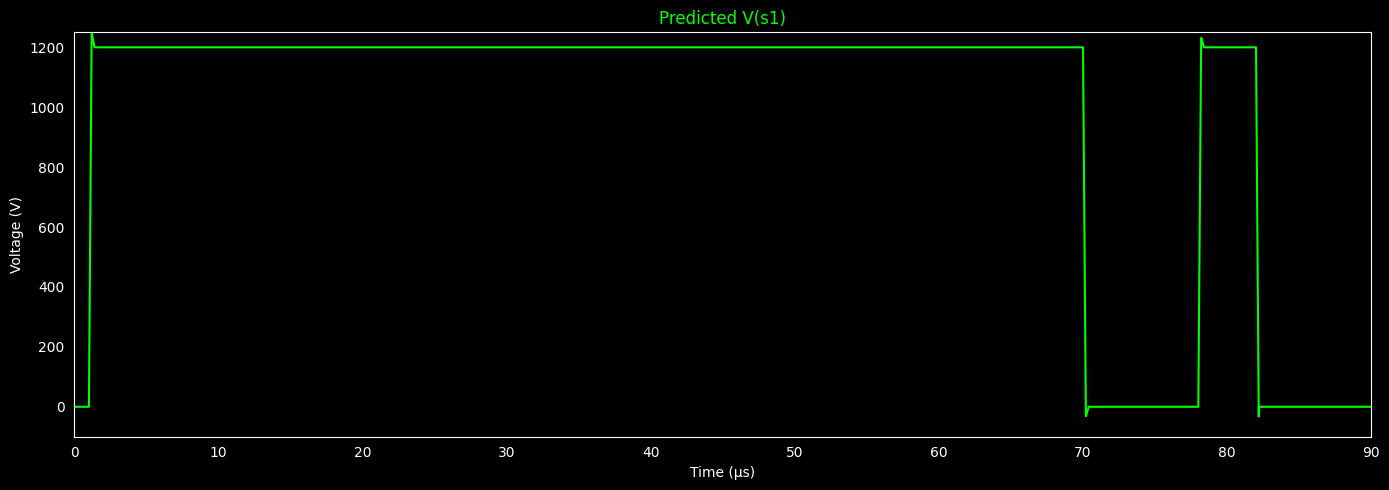

            Event  Time (µs)  True Value (V)  Predicted Value (V)  Difference (Pred-True)
 Pulse1 Overshoot          1        45.60388            47.338090                1.734210
Pulse1 Undershoot         70       -29.40622           -31.258297               -1.852077
 Pulse2 Overshoot         78        41.05481            31.304321               -9.750489
Pulse2 Undershoot         82       -30.08273           -32.134415               -2.051685


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Values from your row ---
Vbus = 1200.0
overshoot_pulse_1_true, overshoot_pulse_1_pred = 45.60388, 47.33809
overshoot_pulse_2_true, overshoot_pulse_2_pred = 41.05481, 31.304321
undershoot_pulse_1_true, undershoot_pulse_1_pred = -29.40622, -31.258297
undershoot_pulse_2_true, undershoot_pulse_2_pred = -30.08273, -32.134415

# --- Timing parameters (µs) ---
t_pulse1_on, t_pulse1_off = 1, 70
t_pulse2_on, t_pulse2_off = 78, 82

# --- Build Predicted waveform only ---
t = np.linspace(0, 90, 10000)
v = np.zeros_like(t)

def fill_linear(mask, v_from, v_to):
    n = np.sum(mask)
    if n > 0:
        v[mask] = np.linspace(v_from, v_to, n)

# Predicted overshoot/undershoot values
V_plateau = Vbus
V_ov1, V_ov2 = V_plateau + overshoot_pulse_1_pred, V_plateau + overshoot_pulse_2_pred
V_un1, V_un2 = undershoot_pulse_1_pred, undershoot_pulse_2_pred

# Pulse 1
fill_linear((t >= t_pulse1_on) & (t < t_pulse1_on+0.2), 0.0, V_ov1)
fill_linear((t >= t_pulse1_on+0.2) & (t < t_pulse1_on+0.4), V_ov1, V_plateau)
v[(t >= t_pulse1_on+0.4) & (t < t_pulse1_off)] = V_plateau
fill_linear((t >= t_pulse1_off) & (t < t_pulse1_off+0.2), V_plateau, V_un1)
fill_linear((t >= t_pulse1_off+0.2) & (t < t_pulse1_off+0.4), V_un1, 0.0)

# Pulse 2
fill_linear((t >= t_pulse2_on) & (t < t_pulse2_on+0.2), 0.0, V_ov2)
fill_linear((t >= t_pulse2_on+0.2) & (t < t_pulse2_on+0.4), V_ov2, V_plateau)
v[(t >= t_pulse2_on+0.4) & (t < t_pulse2_off)] = V_plateau
fill_linear((t >= t_pulse2_off) & (t < t_pulse2_off+0.2), V_plateau, V_un2)
v[(t >= t_pulse2_off+0.2)] = 0.0

# --- Plot predicted waveform ---
plt.figure(figsize=(14,5), facecolor="black")
plt.plot(t, v, color="lime", linewidth=1.5, label="Predicted")
plt.xlim(0, 90); plt.ylim(-100, 1250)
plt.xticks(color="white"); plt.yticks(color="white")
plt.xlabel("Time (µs)", color="white"); plt.ylabel("Voltage (V)", color="white")
plt.title("Predicted V(s1)", color="lime")
plt.gca().set_facecolor("black")
for side in ["bottom","top","right","left"]:
    plt.gca().spines[side].set_color("white")
plt.tight_layout(); plt.show()

# --- Build comparison table ---
data = {
    "Event": ["Pulse1 Overshoot", "Pulse1 Undershoot",
              "Pulse2 Overshoot", "Pulse2 Undershoot"],
    "Time (µs)": [t_pulse1_on, t_pulse1_off,
                  t_pulse2_on, t_pulse2_off],
    "True Value (V)": [overshoot_pulse_1_true, undershoot_pulse_1_true,
                       overshoot_pulse_2_true, undershoot_pulse_2_true],
    "Predicted Value (V)": [overshoot_pulse_1_pred, undershoot_pulse_1_pred,
                            overshoot_pulse_2_pred, undershoot_pulse_2_pred],
    "Difference (Pred-True)": [
        overshoot_pulse_1_pred - overshoot_pulse_1_true,
        undershoot_pulse_1_pred - undershoot_pulse_1_true,
        overshoot_pulse_2_pred - overshoot_pulse_2_true,
        undershoot_pulse_2_pred - undershoot_pulse_2_true
    ]
}
df = pd.DataFrame(data)
print(df.to_string(index=False))
